# Import library

In [2]:
import cv2
import os
from cv2 import imread
from cv2 import fillPoly
from shapely import wkt
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as kutils
import sklearn.ensemble
import sklearn.metrics
import rasterio
import os
import json
import pandas as pd

c:\Users\japan\anaconda3\envs\aia\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\japan\anaconda3\envs\aia\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\japan\anaconda3\envs\aia\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\japan\anaconda3\envs\aia\lib\site-packages\tensorflow\python\framework

# Data pre-processing

We select **Hurricane Mathew** event

## Read image

In [3]:
# define constants
image_folder = 'train/images'
bulding_folder = 'train/buildings'
labels_folder = 'train/labels'

In [4]:
pre_image_files = []
post_image_files = []
pre_building_files = []
post_building_files = []

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_image_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_image_files.append(imread(os.path.join(root, file)))

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_building_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_building_files.append(imread(os.path.join(root, file)))

In [5]:
print(len(pre_image_files))
print(len(post_image_files))

238
238


## Read polygon

In [6]:
count = 0
for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file) and (count==0):
            test = json.load(open(os.path.join(root, file)))
            main_df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            main_df['image'] = file.split('.')[0]
            count += 1
        elif ("hurricane-matthew" in file) and ("post" in file):
            test = json.load(open(os.path.join(root, file)))
            df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            df['image'] = file.split('.')[0]
            main_df = pd.concat([main_df, df], ignore_index=True)

In [7]:
main_df

,wkt,properties.feature_type,properties.subtype,properties.uid,image
0,POLYGON ((-73.73999821958201 18.19645168390706...,building,minor-damage,6dd06e25-353d-4ca2-8a93-bbdd44b10435,hurricane-matthew_00000000_post_disaster
1,POLYGON ((-73.74012695415038 18.19649906723468...,building,minor-damage,29ea07d6-33b5-4c85-9a80-20eea786ab2f,hurricane-matthew_00000000_post_disaster
2,"POLYGON ((-73.74014403688365 18.1965502302046,...",building,minor-damage,25e32d78-3761-443d-8afb-e4b1d575ad30,hurricane-matthew_00000000_post_disaster
3,POLYGON ((-73.74006042030388 18.19652266297088...,building,minor-damage,63591a27-a002-4c86-a02c-e5c4282339cc,hurricane-matthew_00000000_post_disaster
4,POLYGON ((-73.74005471031927 18.19658868660606...,building,minor-damage,5416393e-158e-4bee-9f93-b70df29eab02,hurricane-matthew_00000000_post_disaster
...,...,...,...,...,...
13934,POLYGON ((-74.09714968659425 18.27231201919512...,building,destroyed,ceb3124e-0183-42e8-a26b-38c7844184cf,hurricane-matthew_00000401_post_disaster
13935,POLYGON ((-74.09774801834411 18.27229347634119...,building,destroyed,e748416c-b2f2-4aaf-aefa-89c5ff6468bd,hurricane-matthew_00000401_post_disaster
13936,POLYGON ((-74.09658657078509 18.27343661200825...,building,destroyed,060bbf4b-6dc6-42e1-b325-e75f819ab1f0,hurricane-matthew_00000401_post_disaster
13937,"POLYGON ((-74.09638183743883 18.273897772937, ...",building,destroyed,3627d4d1-2bb5-4406-aec0-00f8a88c87c7,hurricane-matthew_00000401_post_disaster


## Mask Polygon (create ground truth in raster format)

In [8]:
output_path = 'train/mask_polygon'

damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file):
            polygons = json.load(open(os.path.join(root, file)))
            h = polygons["metadata"]["height"]
            w = polygons["metadata"]["width"]
            mask_img = np.zeros((h, w), np.uint8)
            for feature in polygons['features']['xy']:
                feature_poly = wkt.loads(feature['wkt'])
                coords = list(mapping(feature_poly)['coordinates'][0])
                fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feature['properties']['subtype']])
            output_name = file.split('.')[0] + ".png"
            isExist = os.path.exists(output_path)
            if not isExist:
                os.makedirs(output_path)
            cv2.imwrite(os.path.join('train/mask_polygon', output_name), mask_img)

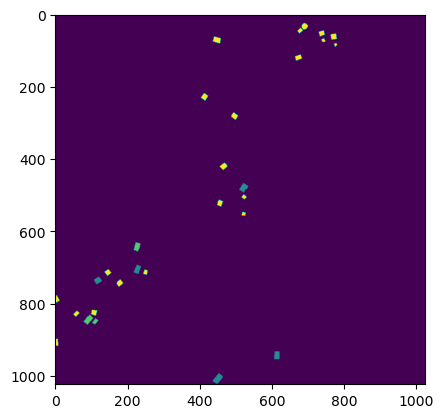

In [9]:
img = mpimg.imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')
imgplot = plt.imshow(img)
plt.show()

In [10]:
test = imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')

In [11]:
np.unique(test)

array([0, 2, 3, 4], dtype=uint8)

## Prepare image patches

This part of code is modified from Classification of very high resolution satellite images using fully convolutional networks (Slum Segmentation Exercise) developed by Konstantin Maslov.

In [12]:
# define constants
BANDS_COUNT = 3
CLASSES_COUNT = 6

PATCH_SIZE = 256
BATCH_SIZE = 10

EPOCHS = 15
STEPS = 200

def read_image(image_path):
    with rasterio.open(image_path) as image_file:
        height, width, depth = image_file.height, image_file.width, image_file.count
        image_arr = np.empty((height, width, depth))
        for band_idx in range(depth):
            band_arr = image_file.read(band_idx + 1)
            image_arr[:, :, band_idx] = band_arr
    return image_arr

def labels_to_onehot(labels_arr):
    height, width, _ = labels_arr.shape
    labels_arr = labels_arr[:, :, 0] 
    labels_onehot = np.zeros((height, width, CLASSES_COUNT))
    for class_idx in range(CLASSES_COUNT):
        labels_onehot[:, :, class_idx][labels_arr == class_idx] = 1
    return labels_onehot

def pad_image_to_patch_size(image, patch_size=PATCH_SIZE):
    height, width, depth = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = np.zeros((target_height, target_width, depth))
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)

In [13]:
class TrainSequence(kutils.Sequence):
    def __init__(self, folder_path, batch_size, patch_size, len):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.len = len
        self.read_dataset()

    def read_dataset(self):
        self.data = []
        pre_image_files = []
        post_image_files = []
        label_files = []
        count = 0
        for root, dirs, files in os.walk(self.folder_path+'/images'):
            for file in files:
                if ("hurricane-matthew" in file) and ("pre" in file):
                    pre_img = imread(os.path.join(root, file))
                    image, _ = pad_image_to_patch_size(pre_img)
                    pre_image_files.append(image)
                    # count += 1
                elif ("hurricane-matthew" in file) and ("post" in file):
                    post_img = imread(os.path.join(root, file))
                    image, _ = pad_image_to_patch_size(post_img)
                    post_image_files.append(image)
                #     count += 1
                # if count == 100:
                #     break
        count = 0
        for root, dirs, files in os.walk(self.folder_path+'/mask_polygon'):
            for file in files:
                label = imread(os.path.join(root, file))
                label, _ = pad_image_to_patch_size(label)
                label = labels_to_onehot(label)
                label_files.append(label)
                # count += 1
                # if count == len(pre_image_files):
                #     break
        
        for i in range(len(pre_image_files)):
            self.data.append((pre_image_files[i], post_image_files[i], label_files[i]))
        print(len(self.data))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        batch_pre_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
        batch_post_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
        batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, CLASSES_COUNT))
        for patch_index in range(self.batch_size):
            image = self.sample_image()
            patch_pre_image, patch_post_image, patch_label = self.sample_patch(image)
            batch_pre_img[patch_index] = patch_pre_image
            batch_post_img[patch_index] = patch_post_image
            batch_y[patch_index] = patch_label
        return batch_pre_img, batch_post_img, batch_y

    def sample_image(self):
        image_index = np.random.choice(len(self.data))
        pre_image, post_image, label = self.data[image_index]
        return pre_image, post_image, label

    def sample_patch(self, image_label_pair):
        pre_image, post_image, label = image_label_pair
        height, width, _ = pre_image.shape
        y = np.random.choice(height - self.patch_size)
        x = np.random.choice(width - self.patch_size)
        patch_pre_image = pre_image[y:y + self.patch_size, x:x + self.patch_size, :]
        patch_post_image = post_image[y:y + self.patch_size, x:x + self.patch_size, :]
        patch_label = label[y:y + self.patch_size, x:x + self.patch_size, :]
        return patch_pre_image, patch_post_image, patch_label

238


[]

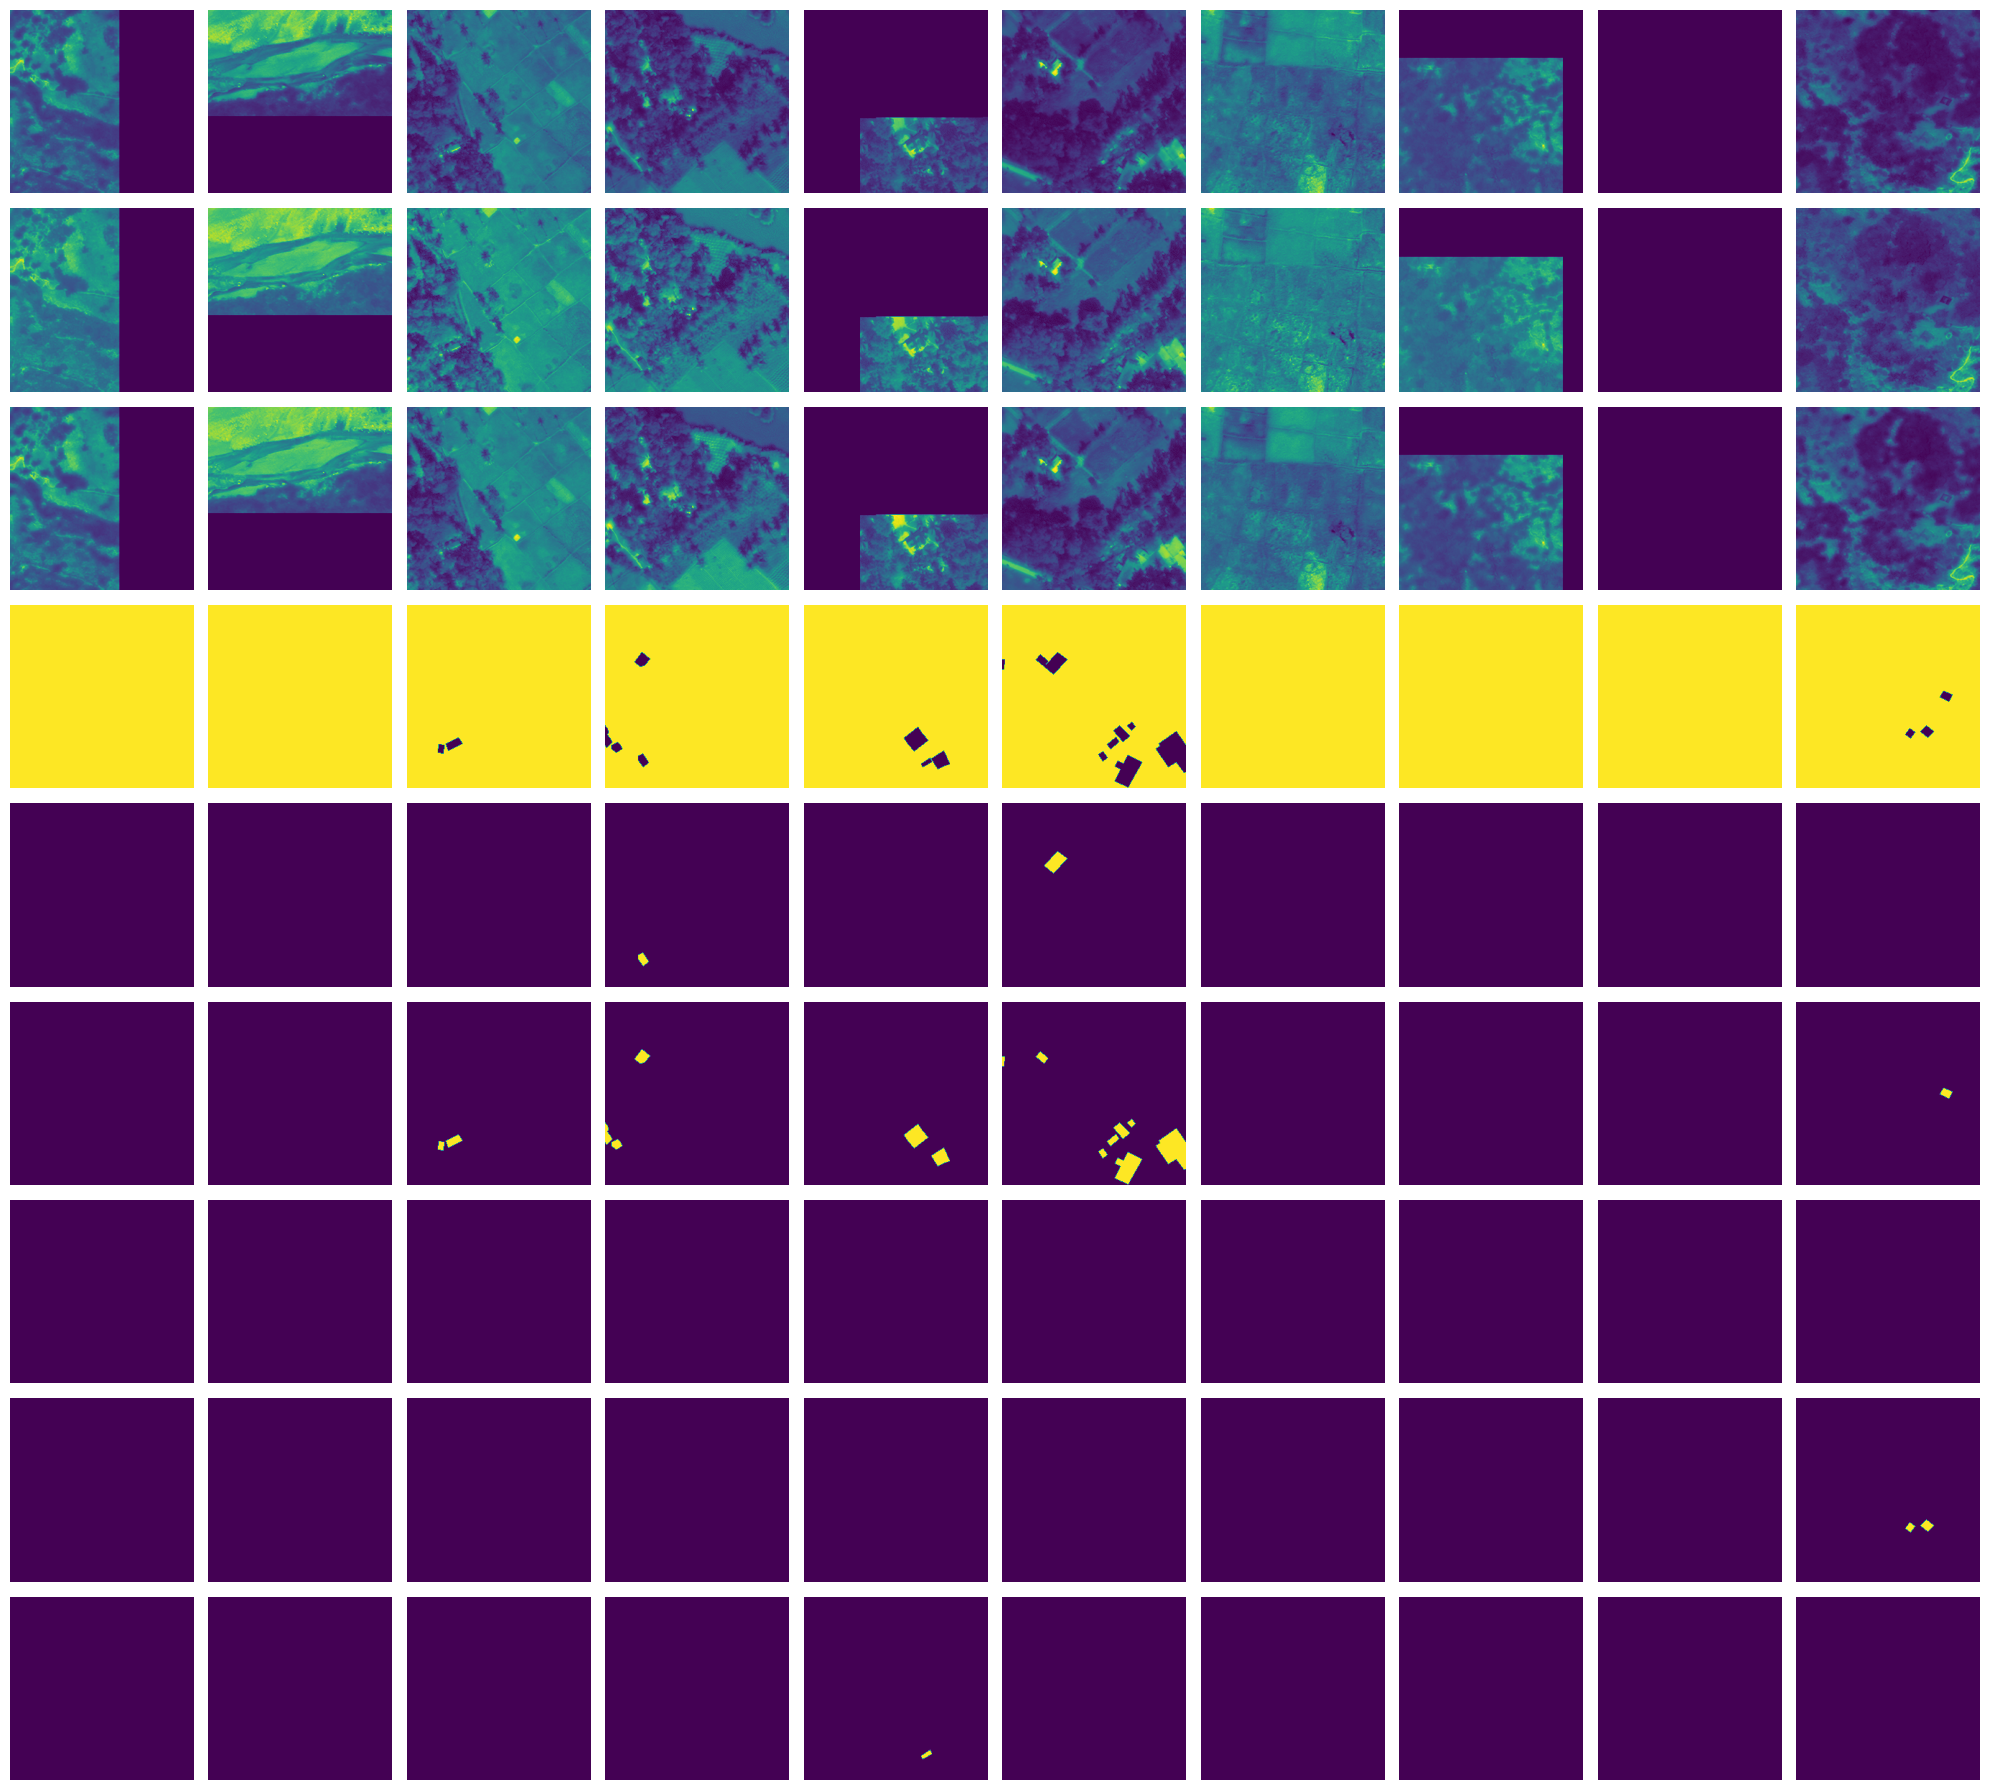

In [14]:
train_sequence = TrainSequence('train', BATCH_SIZE, PATCH_SIZE, STEPS)

pre_img, post_img, y = train_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

for index, (x_item, y_item) in enumerate(zip(pre_img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

In [15]:
print(pre_img.shape)
print(post_img.shape)
print(y.shape)

(10, 256, 256, 3)
(10, 256, 256, 3)
(10, 256, 256, 6)
